# Set up of King Plains unstable case for AMR-Wind

In [1]:
# Load the modules
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend/'  # where amrwind-frontend resides
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/projects/wind_uq/lcheung/naluhelperscripts/venv/lib/python2.7/site-packages/subprocess32.py:149: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [3]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 20000.0)
case.setAMRWindInput('time.max_step',  40000)

case.setAMRWindInput('time.fixed_dt',  0.5)
case.setAMRWindInput('time.checkpoint_interval',  2000)

In [4]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.853e-05)           # viscosity
case.setAMRWindInput('incflo.density',      1.17)                # density

In [5]:
# Set the wind speed and direction
case.setAMRWindInput('useWSDir', True)                           # Allows you to specify wind speed + wind direction 
case.setAMRWindInput('ABL_windspeed', 9.0, forcechange=True)     # Wind speed of 9 m/s
case.setAMRWindInput('ABL_winddir',   175, forcechange=True)     # Wind direction of 175 degrees
case.ABL_calculateWindVector()

In [6]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

In [7]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [   0.0,    0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [10240.0, 10240.0, 2560.0])  # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [512,    512,    128])      # This will make a level 0 mesh that is 20m x 20m x 20m

In [8]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.temperature_type',  'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')      
case.setAMRWindInput('zhi.temperature',       0.003) 

In [9]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',     ['ABLForcing','BoussinesqBuoyancy', 'CoriolisForcing'])

case.setAMRWindInput('ABL.stats_output_frequency',   1)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf')       # Use netcdf output because that's how we postprocess

#case.setAMRWindInput('incflo.velocity',     [8.69, 0.0, 0.0])    # Already taken care of
case.setAMRWindInput('ABLForcing.abl_forcing_height',   91)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.15)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 303.803)        # Correspond to what was measured at ARM
case.setAMRWindInput('ABL.surface_temp_rate',     0.0)            # d(Temperature)/dt ---> set this to zero for unstable ABL
case.setAMRWindInput('ABL.surface_temp_flux',     0.0442)          # Surface temperature flux (K*m/s) --> Use this for unstable ABL's (ITERATE ON THIS TOO)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


In [10]:
case.setAMRWindInput('CoriolisForcing.latitude',  36.57236455833334 )        # Sets up the latitude of the site
case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 303.803)    # The reference temperature

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', '0       1400.0  1500.0  2500.0')
case.setAMRWindInput('ABL.temperature_values',  '305.803 305.803 313.803 314.553')

In [11]:
# This is a case where we don't want to use the defaults in amrwind-frontend
case.setAMRWindInput('ABL.perturb_ref_height', 50.0)
case.setAMRWindInput('ABL.Uperiods', 4.0)
case.setAMRWindInput('ABL.Vperiods', 4.0)
case.setAMRWindInput('ABL.deltaU',   1.0)
case.setAMRWindInput('ABL.deltaV',   1.0)
case.setAMRWindInput('ABL.theta_amplitude',   None)
case.setAMRWindInput('ABL.cutoff_height',   None)

In [12]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        2000)   # Output full domain plot fields every 2,000 iterations/1,000 seconds

# Set up some sampling planes
case.setAMRWindInput('incflo.post_processing',    ['sampling'])            
case.setAMRWindInput('sampling.output_frequency', 1000)         # Output sampling planes every 1000 iterations/500 secs        
case.setAMRWindInput('sampling.fields',           ['velocity', 'temperature'])

In [13]:
sampleplane = case.get_default_samplingdict()
# Set up a sampling plane at two heights: z=60m and z=91m
sampleplane['sampling_name']         = 'p_hub'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [321, 321]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [10240, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 10240, 0]
sampleplane['sampling_p_normal']     = [0, 0, 1]      # This is the direction I want to move/offset the planes
sampleplane['sampling_p_offsets']    = '60 91'        # This is how much to offset the planes
case.add_sampling(sampleplane)

In [14]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     3000,       3000,         3000,       91,     409,     center:specified units:meter centerx:5000 centery:5000 centerz:91 name:A
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [15]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['A']


## Plot the domain

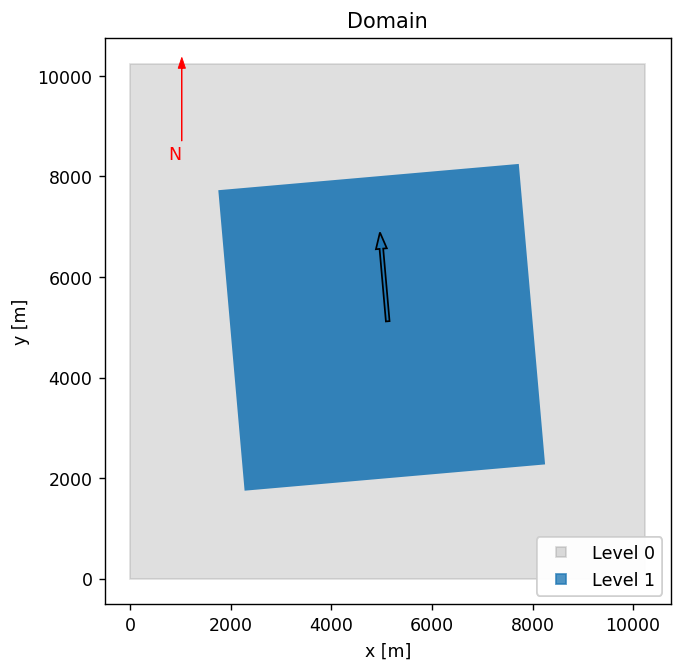

In [16]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
#case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.plotDomain(ax=ax)

Text(0.5,1,'Initial Temp. Profile')

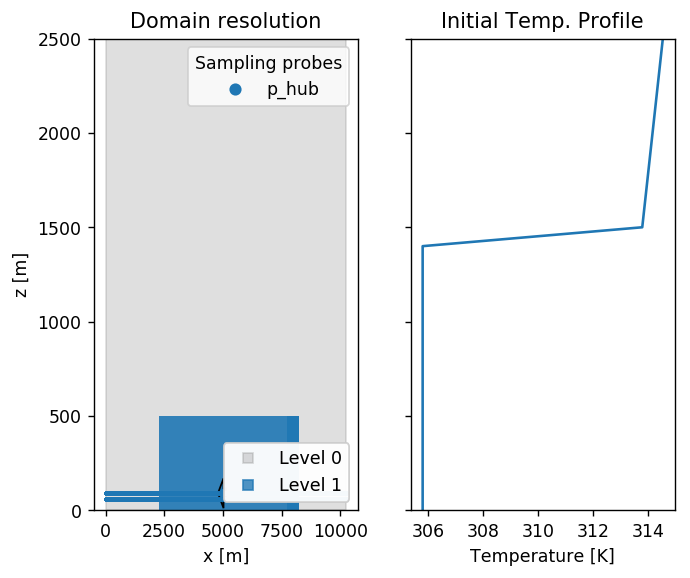

In [17]:
fig, axs = plt.subplots(1,2, figsize=(6,5), facecolor='w', dpi=125, sharey=True)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
#case.popup_storteddata['plotdomain']['plot_refineboxes']     = ['box1', 'box2', 'box3'] 
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
axs[0].axis('auto')
axs[0].set_ylim([0,2500])

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
axs[1].set_ylim([0,2500])
#axs[1].axis('scaled')
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Initial Temp. Profile')

In [18]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

Refinement A: level 1: 18000000 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     33554432             20.0 x 20.0 x 20.0
       1     18000000             10.0 x 10.0 x 10.0
  TOTAL:     51554432


In [19]:
# Check that all inputs are okay
check=case.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ SKIP] Actuator FST:        No Actuators
[ PASS] Sampling probes:p_hub 

Results: 
 4 PASS
 1 SKIP
 0 FAIL
 0 WARN


In [20]:
# Write the input file
print(case.writeAMRWindInput('KingPlains_unstable_precursor4_largerdomain.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 20000.0             # Max (simulated) time to evolve [s]
time.max_step                            = 40000               
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             

## Write a submission file (optional step)

In [21]:
# Set some of the submission script parameters
case.popup_storteddata['submitscript']['submitscript_numnodes'] = 32           
case.popup_storteddata['submitscript']['submitscript_runtime']  = '48:00:00'   # 48 hours
case.popup_storteddata['submitscript']['submitscript_wcid']     = 'fy210193'   # AWAKEN WCID
case.popup_storteddata['submitscript']['submitscript_partition']= 'batch'
case.popup_storteddata['submitscript']['submitscript_corespernode'] = 16       # 16 cores/node
case.popup_storteddata['submitscript']['submitscript_queue']    = 'normal'
case.popup_storteddata['submitscript']['submitscript_jobname']  = 'ABL1'       # name of the job

case.popup_storteddata['submitscript']['submitscript_filename'] = 'submit.sh'  # The name of your submission

In [22]:
# Preview what the submission script looks like
print(case.submitscript_makescript(case.savefile))

#!/bin/bash
#SBATCH --nodes=32
#SBATCH --time=48:00:00        # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
#SBATCH --account=fy210193        # WC ID
#SBATCH --job-name=ABL1    # Name of job
#SBATCH --partition=batch # partition/queue name: short or batch
#SBATCH --qos=normal           # Quality of Service: long, large, priority or normal 
# Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
export nodes=$SLURM_JOB_NUM_NODES

module purge; module load cde/v1/compiler/gcc/7.2.0 cde/v1/gcc/7.2.0/openmpi/3.1.6 cde/v1/gcc/7.2.0/hdf5 cde/v1/gcc/7.2.0/netcdf-c/4.7.3 cde/v1/cmake/3.17.1

# Number MPI processes to run on each node (a.k.a. PPN)
# CTS1 has 36 cores per node and Ghost
#Chama has 16 cores per node
export cores=16
export ncpus=$((nodes * cores))
export OMP_PROC_BIND=spread 
export OMP_PLACES=threads

mpiexec --bind-to core --npernode $cores --n $ncpu

In [23]:
# This will write out submit.sh (and not submit)
case.submitscript_savescript(submit=False)

Saved submit.sh
